<a href="https://colab.research.google.com/github/yoonsongg/CS2/blob/main/Deep_Learning_from_scratch3_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#step1 ~step 5 

In [ ]:
class Variable:
    def __init__(self, data):
        self.data = data

In [ ]:
import numpy as np

data = np.array(1.0)
x = Variable(data)
print(x.data)

1.0


In [ ]:
x.data = np.array(2.0)
print(x.data)

2.0


In [ ]:
x = np.array(1)
x.ndim

0

In [ ]:
class Function:
    def __call__(self, input):
        x = input.data
        y = x ** 2
        output = Variable(y)
        return output

In [ ]:
x = Variable(np.array(10))
f = Function()
y = f(x)

In [ ]:
print(y)
print(type(y))

<class '__main__.Variable'>


In [ ]:
print(y.data)

100


In [ ]:
class Function:
    def __call__(self, input):
        x = input.data #x = input 하면 에러남 (왜 ?????)
        y = self.forward(x)
        output = Variable(y)
        return output

    def forward(self, data):
        raise NotImplementedError()


x = Variable(np.array(10))
g = Function()
h = g(x)
print(h.data)

NotImplementedError: ignored

In [ ]:
#위의 Function 클래스 상속 
class Square(Function):
    def forward(self, x):
        return x ** 2

In [ ]:
x = Variable(np.array(10))
f = Square()
y = f(x)
print(y.data)

100


In [ ]:
class Exp(Function):
    def forward(self, x):
        return np.exp(x)

In [ ]:
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x) #0.5 ** 2
b = B(a) #e ** (0.5**2)
y = C(b). #(e ** (0.5**2)) ** 2
print(y.data)

1.648721270700128


In [ ]:
#f = 미분할 함수
def numerical_diff(f, x, eps=1e-4):
    x0 = Variable(x.data - eps)
    x1 = Variable(x.data + eps)
    y0 = f(x0)
    y1 = f(x1)
    return (y1.data - y0.data) / (2 * eps)

f = Square()
x = Variable(np.array(2.0))
dy = numerical_diff(f, x)
print(dy)


4.000000000004


In [ ]:
def f(x):
    A = Square()
    B = Exp()
    C = Square()
    return C(B(A(x)))

x = Variable(np.array(0.5))
dy = numerical_diff(f, x)
print(dy)

3.2974426293330694


#Step 6 수동역전파

In [ ]:
class Variable:
    def __init__(self, data):
        self.data = data
        self.grad = None

class Function:
    def __call__(self, input):
        x = input.data
        y = self.forward(x)
        output = Variable(y)
        self.input = input
        return output
    
    def forward(self, x):
        raise NotImplementedError
    
    def backward(self, gy):
        raise NotImplementedError
    
class Square(Function):
    def forward(self, x):
        y = x ** 2
        return y
    
    def backward(self, gy):
        x = self.input.data
        gx = 2 * x * gy
        return gx
    

class Exp(Function):
    def forward(self, x):
        y = np.exp(x)
        return y
    
    def backward(self, gy):
        x = self.input.data
        gx = np.exp(x) * gy
        return gx

#순전파하는 코드
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)
print(a.data, b.data, y.data)

#역전파하는 코드 
y.grad = np.array(1.0)
b.grad = C.backward(y.grad) # 2 * 1.28402541(b.data) * 1
a.grad = B.backward(b.grad) #exp(x) * b.grad
x.grad = A.backward(a.grad)

print(b.grad, a.grad, x.grad)


0.25 1.2840254166877414 1.648721270700128
2.568050833375483 3.297442541400256 3.297442541400256


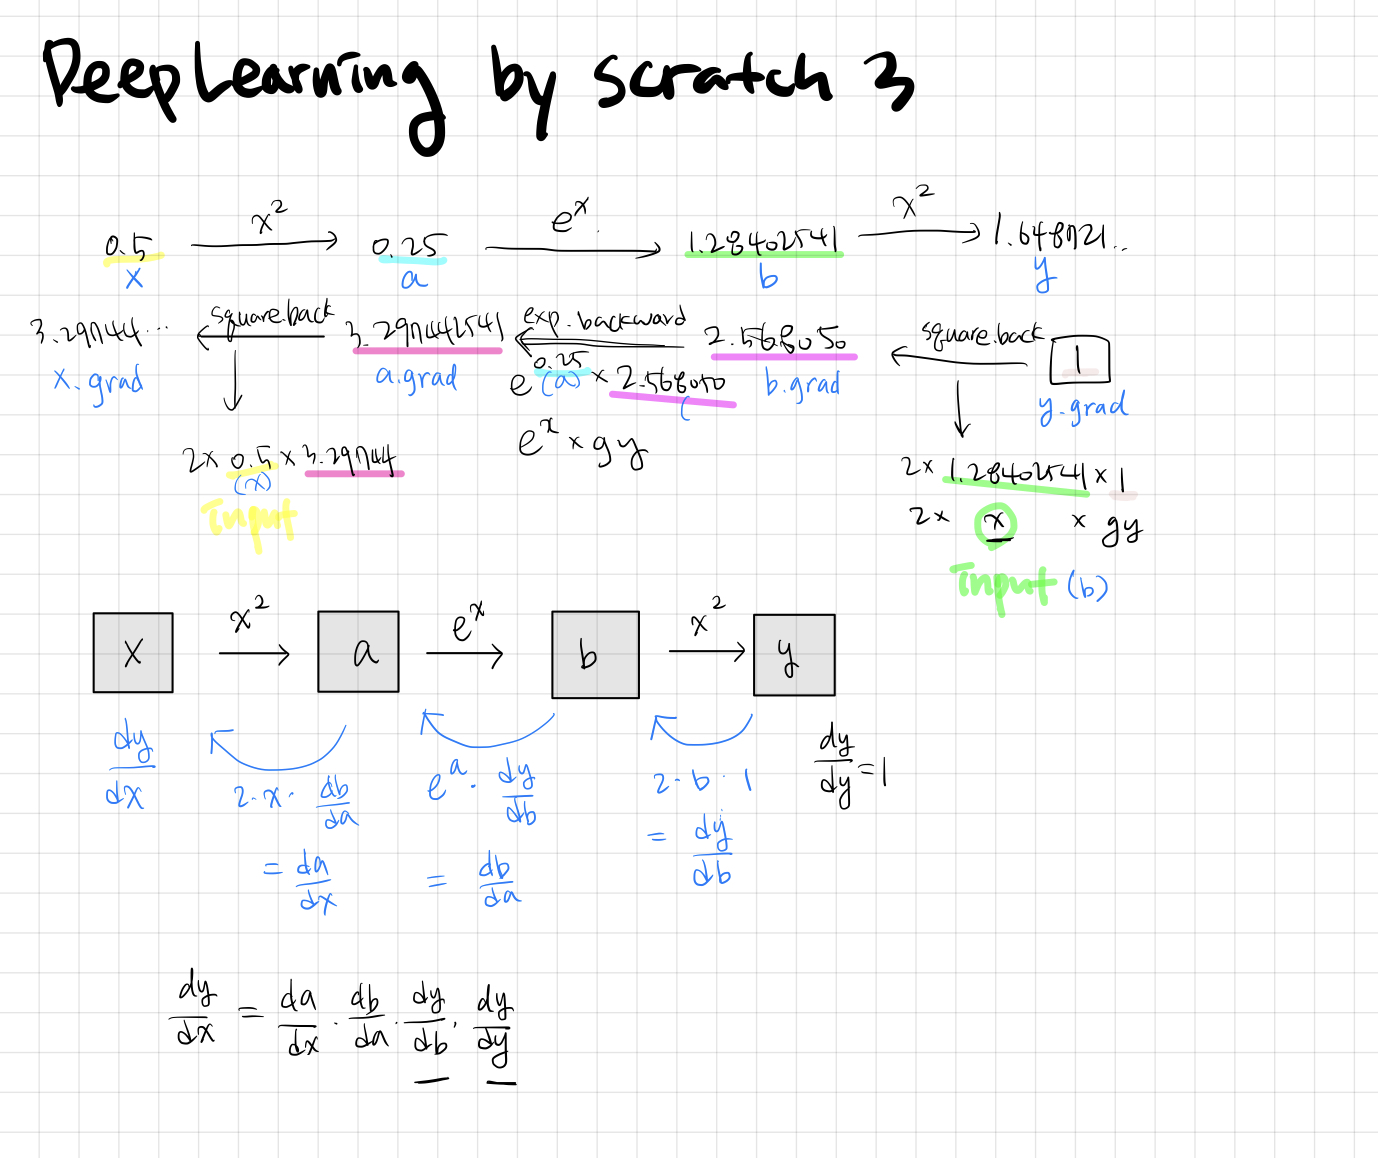

#Step7 역전파 자동화

In [ ]:
class Variable:
    def __init__(self, data):
        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func


class Function:
    def __call__(self, input):
        x = input.data
        y = self.forward(x)
        output = Variable(y)
        output.set_creator(self)
        self.input = input
        self.output = output
        return output

    def forward(self, x):
        raise NotImplementedError
    
    def backward(self, gy):
        raise NotImplementedError
    
class Square(Function):
    def forward(self, x):
        y = x ** 2
        return y
    
    def backward(self, gy):
        x = self.input.data
        gx = 2 * x * gy
        return gx
    

class Exp(Function):
    def forward(self, x):
        y = np.exp(x)
        return y
    
    def backward(self, gy):
        x = self.input.data
        gx = np.exp(x) * gy
        return gx

In [ ]:
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

In [ ]:
assert y.creator == C
assert y.creator.input == b
assert y.creator.input.creator == B

In [ ]:
y.grad = np.array(1.0)

C = y.creator
b = C.input
b.grad = C.backward(y.grad)

In [ ]:
B = b.creator
a = B.input
a.grad = B.backward(b.grad)

In [ ]:
A = a.creator
x = A.input
x.grad = A.backward(a.grad)
print(x.grad)

3.297442541400256


In [ ]:
#위의 과정을 자동화 

class Variable:
    def __init__(self, data):
        self.data = data
        self.grad = None
        self.creator = None
    
    def set_creator(self, func):
        self.creator = func
#자동화하는 부분
    def backward(self):
        f = self.creator
        if f is not None:
            x = f.input
            x.grad = f.backward(self.grad)
            x.backward()



#step8 재귀에서 반복문

In [ ]:
#위의 재귀 말고 반복문으로 

class Variable:
    def __init__(self, data):
        self.data = data
        self.grad = None
        self.creator = None
    
    def set_creator(self, func):
        self.creator = func

    def backward(self):
        funcs = [self.creator]
        while funcs:
            print(funcs)
            f = funcs.pop()
            x, y = f.input, f.output
            x.grad = f.backward(y.grad)
            print('----')

            if x.creator is not None:
                funcs.append(x.creator)
                print('**' , funcs)

In [ ]:
class Function:
    def __call__(self, input):
        x = input.data
        y = self.forward(x)
        output = Variable(y)
        output.set_creator(self)
        self.input = input
        self.output = output
        return output

    def forward(self, x):
        raise NotImplementedError
    
    def backward(self, gy):
        raise NotImplementedError
    
class Square(Function):
    def forward(self, x):
        y = x ** 2
        return y
    
    def backward(self, gy):
        x = self.input.data
        gx = 2 * x * gy
        return gx
    

class Exp(Function):
    def forward(self, x):
        y = np.exp(x)
        return y
    
    def backward(self, gy):
        x = self.input.data
        gx = np.exp(x) * gy
        return gx

In [ ]:
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

In [ ]:
y.grad = np.array(1.0)
y.backward()
print(x.grad)
#여기 모르겠음. 왜 append 하고 pop 해서 쓰는지. 그러면 애초에 funcs에는 creator 없는건가? 다 있는건가? 

----
** [<__main__.Exp object at 0x7f29b13d2090>]
----
** [<__main__.Square object at 0x7f29b13d2d10>]
----
3.297442541400256


#step9 함수를 더 편리하게

In [ ]:
class Variable:
    def __init__(self, data):
        #only ndarray 만 가능하도록
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('f{}은 지원하지 않습니다.', type(data))

        self.data = data
        self.grad = None
        self.creator = None
    
    def set_creator(self, func):
        self.creator = func

    def backward(self):
        #매번 y.grad = np.array(1.0) 쓰기 구찮(so 아래 두줄)
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = [self.creator]
        while funcs:
            f = funcs.pop()
            x, y = f.input, f.output
            x.grad = f.backward(y.grad)
 
            if x.creator is not None:
                funcs.append(x.creator)

#편의를 위한 함수
def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x
            
class Function:
    def __call__(self, input):
        x = input.data
        y = self.forward(x)
        #편의를 위한 함수 사용
        #output = Variable(y)
        output = Variable(as_array(y))
        output.set_creator(self)
        self.input = input
        self.output = output
        return output

    def forward(self, x):
        raise NotImplementedError
    
    def backward(self, gy):
        raise NotImplementedError
    
class Square(Function):
    def forward(self, x):
        y = x ** 2
        return y
    
    def backward(self, gy):
        x = self.input.data
        gx = 2 * x * gy
        return gx
    

class Exp(Function):
    def forward(self, x):
        y = np.exp(x)
        return y
    
    def backward(self, gy):
        x = self.input.data
        gx = np.exp(x) * gy
        return gx

In [ ]:
#매번 선언하기 귀찮. 그래서 다시 함수구현
def square(x):
    return Square()(x)
def exp(x):
    return Exp()(x)

In [ ]:
x = Variable(np.array(0.5))
y = square(exp(square(x)))
#위의 Variable class 고쳐서 아래 생략 가능
#y.grad = np.array(1.0)

y.backward()
print(x.grad)

3.297442541400256
